In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.signal as signal
import torch.distributions as dist
from jaxtyping import Float, Int
from torch import Tensor
import spikeinterface.extractors as se
import spikeinterface.comparison as sc
from spikeinterface.preprocessing import bandpass_filter
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from scipy.signal import find_peaks
import h5py
import spikeinterface.sorters as ss
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

In [4]:
def load_mearec_data(recording_file="recordings.h5"):
    """
    Load MEArec data and convert to PyTorch tensors compatible with the notebook format
    """
    # Load MEArec data
    recording, sorting_true = se.read_mearec(recording_file)
    
    # Apply preprocessing (bandpass filter)
    recording_filt = bandpass_filter(recording, freq_min=300, freq_max=6000)
    
    # Get traces as numpy array and convert to torch tensor
    traces = torch.tensor(recording_filt.get_traces(), dtype=torch.float32)
    
    # Get ground truth spike times and IDs
    true_spike_times = []
    true_spike_ids = []
    
    for unit_id in sorting_true.unit_ids:
        unit_spikes = sorting_true.get_unit_spike_train(unit_id)
        true_spike_times.extend(unit_spikes)
        # Convert unit_id to integer (remove '#' if present)
        unit_idx = int(unit_id.lstrip('#')) if isinstance(unit_id, str) else int(unit_id)
        true_spike_ids.extend([unit_idx] * len(unit_spikes))
    
    # Sort by spike times
    sorted_indices = np.argsort(true_spike_times)
    true_spike_times = torch.tensor([true_spike_times[i] for i in sorted_indices], dtype=torch.long)
    true_spike_ids = torch.tensor([true_spike_ids[i] for i in sorted_indices], dtype=torch.long)
    
    # Extract true templates from MEArec data
    with h5py.File(recording_file, 'r') as f:
        templates = f['templates'][:]  # Shape: (n_units, n_jitters, n_channels, n_samples)
        
    # Convert templates to the expected format: (n_units, n_samples, n_channels)
    # Take median across jitters and transpose
    true_templates = torch.tensor(np.median(templates, axis=1).transpose(0, 2, 1), dtype=torch.float32)
    
    # Constants
    sampling_frequency = recording.sampling_frequency
    num_samples, num_channels = traces.shape
    true_num_spikes = len(true_spike_times)
    true_num_neurons, window_size, _ = true_templates.shape
    
    return {
        'traces': traces,
        'true_spike_times': true_spike_times,
        'true_spike_ids': true_spike_ids,
        'true_templates': true_templates,
        'sampling_frequency': sampling_frequency,
        'num_samples': num_samples,
        'num_channels': num_channels,
        'true_num_spikes': true_num_spikes,
        'true_num_neurons': true_num_neurons,
        'window_size': window_size
    }

In [5]:
data = load_mearec_data("data/sim_data/recordings2.h5")

# Extract variables in the same format as the original notebook
traces = data['traces']
true_spike_times = data['true_spike_times']
true_spike_ids = data['true_spike_ids']
true_templates = data['true_templates']

SAMPLING_FREQUENCY = data['sampling_frequency']
NUM_SAMPLES, NUM_CHANNELS = traces.shape
TRUE_NUM_SPIKES = data['true_num_spikes']
TRUE_NUM_NEURONS, WINDOW_SIZE, _ = true_templates.shape

print(f"✅ Loaded MEArec data:")
print(f"   Traces shape: {traces.shape}")
print(f"   True spikes: {TRUE_NUM_SPIKES}")
print(f"   True neurons: {TRUE_NUM_NEURONS}")
print(f"   Sampling frequency: {SAMPLING_FREQUENCY} Hz")
print(f"   Window size: {WINDOW_SIZE}")

✅ Loaded MEArec data:
   Traces shape: torch.Size([1920000, 32])
   True spikes: 4805
   True neurons: 8
   Sampling frequency: 32000.0 Hz
   Window size: 416


In [6]:
def plot_slice(traces: Float[Tensor, "num_samples num_channels"],
               spike_times: Int[Tensor, "num_spikes"],
               spike_ids: Int[Tensor, "num_spikes"],
               start_time: float=0,
               end_time: float=1.0,
               ylim: float=None):
    """
    Plot a slice of the recording and the corresponding spike times.
    """
    # Extract constants
    num_samples, num_channels = traces.shape
    num_neurons = spike_ids.max() + 1
    
    # Extract the slice of the recording
    slc = slice(int(start_time * SAMPLING_FREQUENCY), int(end_time * SAMPLING_FREQUENCY))
    
    # Get the y-limit for traces if not specified
    if ylim is None:
        ylim = 1.05 * traces[slc].abs().max()
    
    # Make an array of times in seconds
    times_sec = torch.arange(0, num_samples) / SAMPLING_FREQUENCY
    spike_times_sec = times_sec[spike_times]
    spike_in_slice = (spike_times_sec >= start_time) & (spike_times_sec <= end_time)
    
    # Plot the spike raster
    fig, axs = plt.subplots(num_channels + 1, 1, sharex=True, figsize=(6, 1.5 * (num_channels + 1)))
    
    axs[0].plot(spike_times_sec[spike_in_slice], spike_ids[spike_in_slice], '|k', markersize=6)
    axs[0].set_ylabel("neuron")
    axs[0].set_yticks(torch.arange(0, num_neurons))
    axs[0].set_title("spike train")
    
    # Plot the voltage traces
    for i in range(num_channels):
        axs[i+1].plot(times_sec[slc], traces[slc, i], color='k', lw=1, alpha=0.5)
        axs[i+1].set_title(f"channel {i+1}", fontsize=10)
        axs[i+1].set_ylim(-ylim, ylim)
        axs[i+1].set_ylabel("trace\n[z-score]")
        axs[i+1].set_xlim(start_time, end_time)
        if i == num_channels - 1:
            axs[i+1].set_xlabel(f"time [sec]")
    
    plt.tight_layout()
    return fig, axs

In [7]:
def plot_waveforms(waveforms: Float[Tensor, "num_waveforms windows_size num_channels"],
                   name: str="waveform"):
    """
    Plot a grid of spike waveforms or templates.
    """
    num_waveforms, window_size, num_channels = waveforms.shape
    times = torch.arange(-window_size//2, window_size//2) / SAMPLING_FREQUENCY * 1000
    
    fig, axs = plt.subplots(num_channels, num_waveforms,
                           figsize=(1.25 * num_waveforms, 1.25 * num_channels),
                           sharex=True, sharey=True)
    
    # Handle case where there's only one channel or one waveform
    if num_channels == 1:
        axs = axs.reshape(1, -1)
    if num_waveforms == 1:
        axs = axs.reshape(-1, 1)
    
    lim = 1.05 * waveforms.abs().max()
    
    for j in range(num_waveforms):
        for i in range(num_channels):
            axs[i,j].plot(times, waveforms[j,:,i], color='k', lw=1, alpha=0.5)
            axs[i,j].set_ylim(-lim, lim)
            
            if j == 0:
                axs[i,j].set_ylabel(f"channel {i}\n [z-score]")
            if i == 0:
                axs[i,j].set_title(f"{name} {j}")
            if i == num_channels - 1:
                axs[i,j].set_xlabel(f"time [ms]")
    
    plt.tight_layout()
    return fig, axs

In [8]:
def evaluate_detected_spikes(
    detected_spike_times: Int[Tensor, "num_detected_spikes"],
    true_spike_times: Int[Tensor, "num_true_spikes"]) -> dict:
    """
    Evaluate detected spikes against ground truth with boundary handling
    """
    num_windows = NUM_SAMPLES // WINDOW_SIZE
    
    # Filter out spikes that would cause out-of-bounds errors
    # Keep only spikes that fall within valid window boundaries
    valid_true_spikes = true_spike_times[true_spike_times < num_windows * WINDOW_SIZE]
    valid_detected_spikes = detected_spike_times[detected_spike_times < num_windows * WINDOW_SIZE]
    
    # Create masks for windows containing spikes
    true_spike_mask = torch.zeros(num_windows, dtype=torch.bool)
    if len(valid_true_spikes) > 0:
        true_spike_mask[valid_true_spikes // WINDOW_SIZE] = True
    
    detected_spike_mask = torch.zeros(num_windows, dtype=torch.bool)
    if len(valid_detected_spikes) > 0:
        detected_spike_mask[valid_detected_spikes // WINDOW_SIZE] = True
    
    # Calculate confusion matrix elements
    tp = (true_spike_mask & detected_spike_mask).sum().item()
    fp = (detected_spike_mask & ~true_spike_mask).sum().item()
    fn = (~detected_spike_mask & true_spike_mask).sum().item()
    tn = (~detected_spike_mask & ~true_spike_mask).sum().item()
    
    return dict(tp=tp, fp=fp, fn=fn, tn=tn)

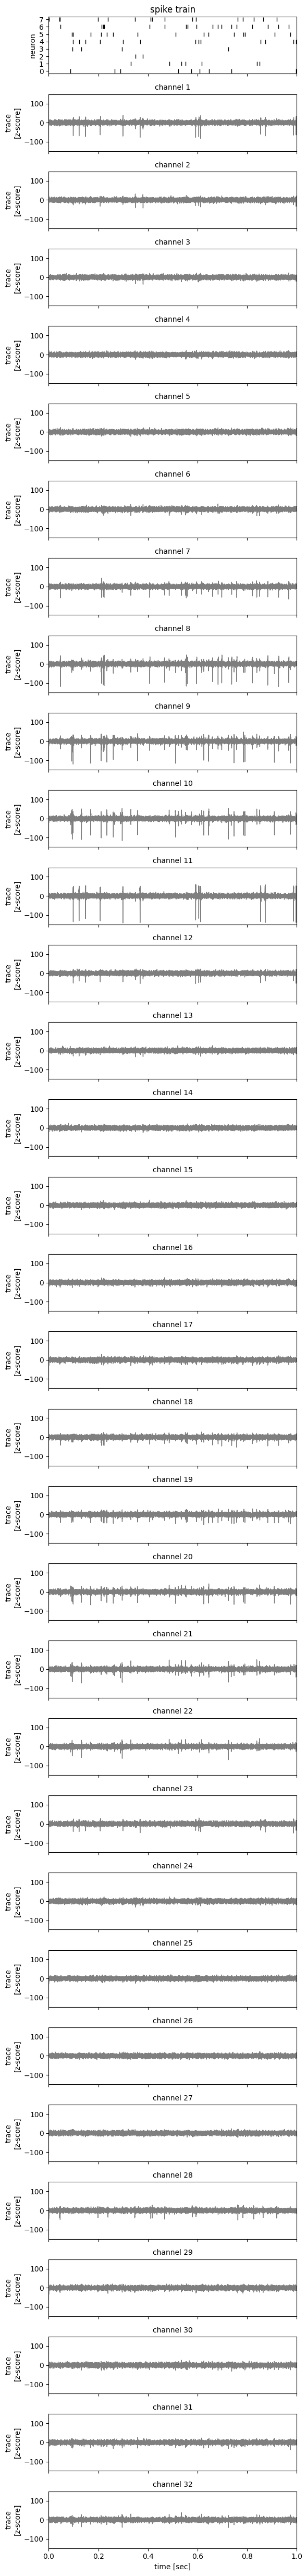

In [9]:
# Plot the first second of MEArec data
_ = plot_slice(traces, true_spike_times, true_spike_ids, start_time=0.0, end_time=1.0)

In [13]:
# Convert back to SpikeInterface format temporarily
recording_si = se.read_mearec("data/sim_data/recordings2.h5")[0]
recording_filt = bandpass_filter(recording_si, freq_min=300, freq_max=6000)

# Detect peaks using SpikeInterface
peaks = detect_peaks(recording_filt, 
                    method='locally_exclusive',
                    peak_sign='neg',
                    detect_threshold=5.0,
                    exclude_sweep_ms=1.0)

# Convert back to torch tensors
si_spike_times = torch.tensor(peaks['sample_index'])
print(f"✅ SpikeInterface detected {len(si_spike_times)} spikes")

detected_spike_times = si_spike_times
traces_np = recording_filt.get_traces()

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

detect peaks using locally_exclusive (no parallelization):   0%|          | 0/60 [00:00<?, ?it/s]

✅ SpikeInterface detected 4713 spikes


Extracting waveforms with window size 416...
Skipping spike 0: out of bounds (start=-206, end=210)
Skipping spike 1: out of bounds (start=-200, end=216)
Skipping spike 4712: out of bounds (start=1919701, end=1920117)
✅ Extracted 4710 valid waveforms


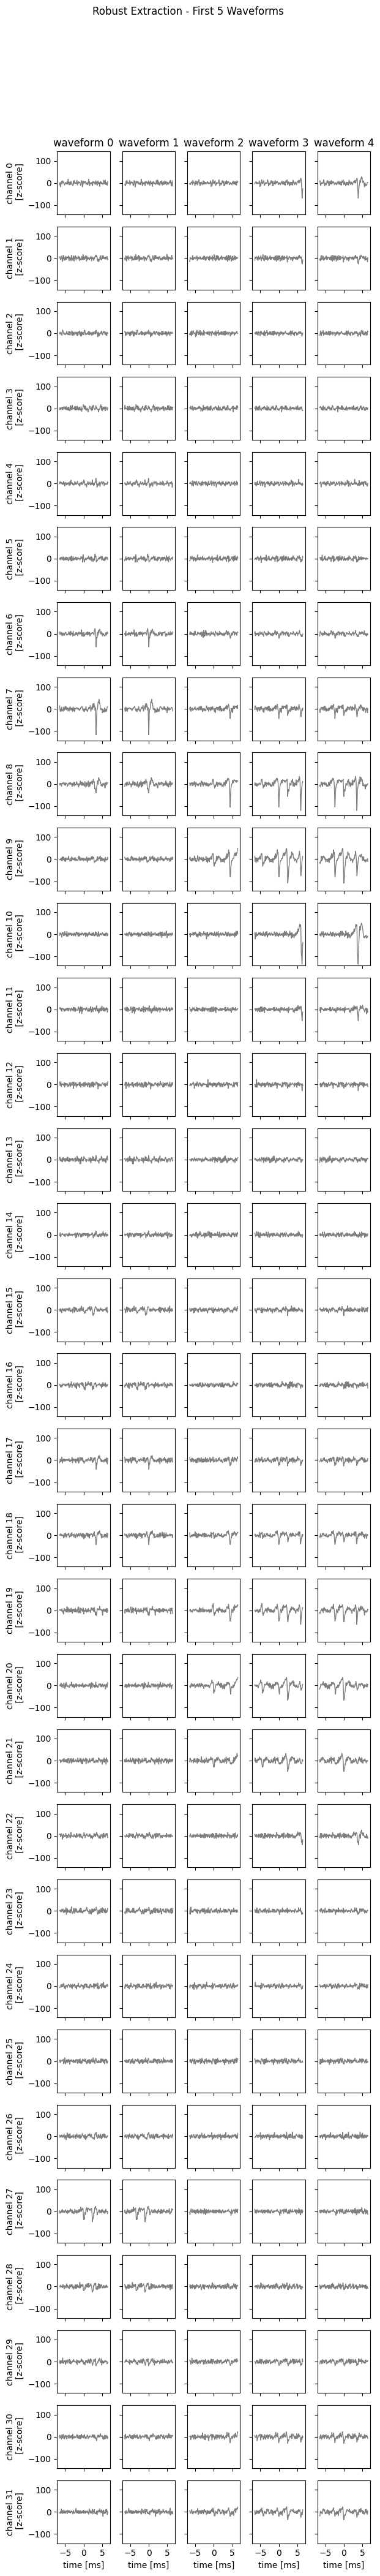

In [14]:
def extract_waveforms_robust(traces_np, spike_times, window_size):
    """
    Robust waveform extraction with proper boundary handling
    """
    num_spikes = len(spike_times)
    num_samples, num_channels = traces_np.shape
    half_window = window_size // 2
    
    spike_waveforms = []
    valid_spike_times = []
    
    print(f"Extracting waveforms with window size {window_size}...")
    
    for i, t in enumerate(spike_times):
        start_idx = int(t - half_window)
        end_idx = int(t + half_window)
        
        # Check boundaries
        if start_idx >= 0 and end_idx < num_samples:
            waveform = traces_np[start_idx:end_idx, :]
            
            # Verify we got the right shape
            if waveform.shape[0] == window_size:
                spike_waveforms.append(torch.tensor(waveform))
                valid_spike_times.append(t)
            else:
                print(f"Skipping spike {i}: wrong shape {waveform.shape}")
        else:
            print(f"Skipping spike {i}: out of bounds (start={start_idx}, end={end_idx})")
    
    if len(spike_waveforms) > 0:
        spike_waveforms = torch.stack(spike_waveforms)
        print(f"✅ Extracted {len(spike_waveforms)} valid waveforms")
    else:
        print("❌ No valid waveforms extracted!")
        spike_waveforms = torch.zeros((0, window_size, num_channels))
    
    return spike_waveforms, torch.tensor(valid_spike_times)


# Apply robust extraction
spike_waveforms_fixed, valid_spike_times = extract_waveforms_robust(
    traces_np, si_spike_times, WINDOW_SIZE
)



# Plot the results
if len(spike_waveforms_fixed) > 0:
    fig, axs = plot_waveforms(spike_waveforms_fixed[:5], name="waveform")
    fig.suptitle("Robust Extraction - First 5 Waveforms", y=1.05)
    plt.show()
else:
    print("No waveforms to plot!")

In [16]:
def template_free_dtw_spike_sorting(spike_waveforms, n_expected_neurons=5):
    """
    Template-free DTW spike sorting based on PMC4749467 methodology
    """
    print("🔬 Template-Free DTW Spike Sorting")
    print("="*50)
    
    # Step 1: Quality filtering (like your Template 3 analysis)
    amplitudes = torch.max(torch.abs(spike_waveforms), dim=1)[0].max(dim=1)[0]
    quality_threshold = torch.quantile(amplitudes, 0.7)  # Top 30% by amplitude
    quality_mask = amplitudes > quality_threshold
    
    quality_spikes = spike_waveforms[quality_mask]
    print(f"Quality filtering: {len(quality_spikes)}/{len(spike_waveforms)} spikes retained")
    
    # Step 2: Initial rough clustering (PCA + K-means)
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    
    # Flatten and normalize spikes
    flat_spikes = quality_spikes.reshape(len(quality_spikes), -1)
    flat_spikes_norm = flat_spikes / (torch.norm(flat_spikes, dim=1, keepdim=True) + 1e-8)
    
    # PCA for initial grouping
    pca = PCA(n_components=10)
    spike_features = pca.fit_transform(flat_spikes_norm)
    
    # K-means for initial clusters
    kmeans = KMeans(n_clusters=n_expected_neurons, random_state=42)
    initial_labels = kmeans.fit_predict(spike_features)
    
    # Step 3: Create templates from initial clusters (PMC4749467 approach)
    estimated_templates = []
    for cluster_id in range(n_expected_neurons):
        cluster_mask = initial_labels == cluster_id
        if np.sum(cluster_mask) > 5:  # Need minimum spikes per cluster
            # Use median as in PMC4749467: "taking the median of the spikes"
            cluster_spikes = quality_spikes[cluster_mask]
            template = torch.median(cluster_spikes, dim=0)[0]
            estimated_templates.append(template)
    
    print(f"✅ Estimated {len(estimated_templates)} templates from initial clustering")
    
    # Step 4: DTW-based refinement using estimated templates
    if len(estimated_templates) > 0:
        # Use primary channel for DTW (max variance)
        primary_ch = torch.argmax(torch.var(quality_spikes.reshape(-1, quality_spikes.shape[-1]), dim=0))
        
        # Normalize templates and spikes
        norm_templates = []
        for template in estimated_templates:
            norm_template = template[:, primary_ch]
            norm_template = norm_template / (torch.norm(norm_template) + 1e-8)
            norm_templates.append(norm_template.numpy())
        
        # DTW classification of all quality spikes
        dtw_labels = []
        for spike in quality_spikes:
            norm_spike = spike[:, primary_ch]
            norm_spike = norm_spike / (torch.norm(norm_spike) + 1e-8)
            norm_spike = norm_spike.numpy()
            
            # Compute DTW distance to each template
            distances = []
            for template in norm_templates:
                distance, _ = fastdtw(norm_spike, template, radius=3)
                distances.append(distance)
            
            # Assign to closest template or reject as noise
            min_dist_idx = np.argmin(distances)
            min_dist = distances[min_dist_idx]
            
            # Automatic threshold as in PMC4749467
            threshold = np.mean(distances) + np.std(distances)
            
            if min_dist < threshold:
                dtw_labels.append(min_dist_idx)
            else:
                dtw_labels.append(-1)  # Noise
        
        dtw_labels = np.array(dtw_labels)
        
        # Map back to full spike set
        full_labels = np.full(len(spike_waveforms), -1)
        full_labels[quality_mask] = dtw_labels
        
        return {
            'labels': torch.tensor(full_labels),
            'estimated_templates': torch.stack(estimated_templates) if estimated_templates else None,
            'quality_mask': quality_mask,
            'n_templates': len(estimated_templates)
        }
    
    else:
        print("❌ Failed to estimate templates")
        return None

# Run template-free DTW
template_free_results = template_free_dtw_spike_sorting(spike_waveforms_fixed, n_expected_neurons=5)



🔬 Template-Free DTW Spike Sorting
Quality filtering: 1413/4710 spikes retained
✅ Estimated 5 templates from initial clustering


KeyboardInterrupt: 

In [ ]:
def template_free_dtw_spike_sorting(spike_waveforms, n_expected_neurons=5):
    """
    Template-free DTW spike sorting with progress tracking
    Based on PMC4749467 methodology with tqdm progress bars
    """
    print("🔬 Template-Free DTW Spike Sorting with Progress Tracking")
    print("="*60)
    
    # Step 1: Quality filtering (like your Template 3 analysis)
    print("📊 Step 1: Quality filtering...")
    amplitudes = torch.max(torch.abs(spike_waveforms), dim=1)[0].max(dim=1)[0]
    quality_threshold = torch.quantile(amplitudes, 0.7)  # Top 30% by amplitude
    quality_mask = amplitudes > quality_threshold
    
    quality_spikes = spike_waveforms[quality_mask]
    print(f"Quality filtering: {len(quality_spikes)}/{len(spike_waveforms)} spikes retained")
    
    if len(quality_spikes) < 10:
        print("❌ Insufficient quality spikes for clustering")
        return None
    
    # Step 2: Initial rough clustering (PCA + K-means)
    print("🎯 Step 2: Initial clustering...")
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    
    # Flatten and normalize spikes with progress bar
    flat_spikes = quality_spikes.reshape(len(quality_spikes), -1)
    
    print("Normalizing spikes...")
    normalized_spikes = []
    for spike in tqdm(flat_spikes, desc="Normalizing", unit="spike"):
        norm_spike = spike / (torch.norm(spike) + 1e-8)
        normalized_spikes.append(norm_spike)
    flat_spikes_norm = torch.stack(normalized_spikes)
    
    # PCA for initial grouping
    print("Computing PCA features...")
    pca = PCA(n_components=10)
    spike_features = pca.fit_transform(flat_spikes_norm.numpy())
    
    # K-means for initial clusters
    print(f"Running K-means clustering (k={n_expected_neurons})...")
    kmeans = KMeans(n_clusters=n_expected_neurons, random_state=42, verbose=1)
    initial_labels = kmeans.fit_predict(spike_features)
    
    # Step 3: Create templates from initial clusters
    print("🔧 Step 3: Template estimation...")
    estimated_templates = []
    template_info = []
    
    for cluster_id in tqdm(range(n_expected_neurons), desc="Creating templates", unit="cluster"):
        cluster_mask = initial_labels == cluster_id
        cluster_size = np.sum(cluster_mask)
        
        if cluster_size > 5:  # Need minimum spikes per cluster
            cluster_spikes = quality_spikes[cluster_mask]
            
            # Use median as in PMC4749467: "taking the median of the spikes"
            template = torch.median(cluster_spikes, dim=0)[0]
            estimated_templates.append(template)
            template_info.append({
                'cluster_id': cluster_id,
                'n_spikes': cluster_size,
                'template_amplitude': torch.max(torch.abs(template)).item()
            })
            
            print(f"  Template {cluster_id}: {cluster_size} spikes, "
                  f"amplitude: {torch.max(torch.abs(template)):.2f}")
    
    print(f"✅ Estimated {len(estimated_templates)} templates from initial clustering")
    
    if len(estimated_templates) == 0:
        print("❌ No valid templates estimated")
        return None
    
    # Step 4: DTW-based refinement using estimated templates
    print("⚡ Step 4: DTW refinement...")
    
    # Use primary channel for DTW (max variance)
    all_spikes_flat = quality_spikes.reshape(-1, quality_spikes.shape[-1])
    primary_ch = torch.argmax(torch.var(all_spikes_flat, dim=0))
    print(f"Using primary channel: {primary_ch}")
    
    # Normalize templates
    print("Normalizing templates...")
    norm_templates = []
    for i, template in enumerate(tqdm(estimated_templates, desc="Template norm", unit="template")):
        norm_template = template[:, primary_ch]
        norm_template = norm_template / (torch.norm(norm_template) + 1e-8)
        norm_templates.append(norm_template.numpy())
    
    # DTW classification of all quality spikes
    print("🔄 Running DTW classification...")
    dtw_labels = []
    dtw_distances_all = []
    
    # Progress bar for DTW classification
    for spike_idx, spike in enumerate(tqdm(quality_spikes, 
                                          desc="DTW classification", 
                                          unit="spike",
                                          leave=True)):
        norm_spike = spike[:, primary_ch]
        norm_spike = norm_spike / (torch.norm(norm_spike) + 1e-8)
        norm_spike = norm_spike.numpy()
        
        # Compute DTW distance to each template
        distances = []
        for template_idx, template in enumerate(norm_templates):
            try:
                distance, _ = fastdtw(norm_spike, template, radius=3)
                distances.append(distance)
            except Exception as e:
                print(f"DTW failed for spike {spike_idx}, template {template_idx}: {e}")
                distances.append(float('inf'))
        
        dtw_distances_all.append(distances)
        
        # Assign to closest template or reject as noise
        if len(distances) > 0 and min(distances) < float('inf'):
            min_dist_idx = np.argmin(distances)
            min_dist = distances[min_dist_idx]
            
            # Automatic threshold as in PMC4749467
            threshold = np.mean(distances) + np.std(distances)
            
            if min_dist < threshold:
                dtw_labels.append(min_dist_idx)
            else:
                dtw_labels.append(-1)  # Noise
        else:
            dtw_labels.append(-1)  # Failed DTW
    
    dtw_labels = np.array(dtw_labels)
    dtw_distances_all = np.array(dtw_distances_all)
    
    # Map back to full spike set
    print("📋 Step 5: Mapping results...")
    full_labels = np.full(len(spike_waveforms), -1)
    full_labels[quality_mask] = dtw_labels
    
    # Calculate statistics
    n_classified = np.sum(dtw_labels >= 0)
    n_noise = np.sum(dtw_labels == -1)
    
    print(f"\n✅ DTW Template-Free Results:")
    print(f"   Processing time: Complete")
    print(f"   Templates estimated: {len(estimated_templates)}")
    print(f"   Quality spikes: {len(quality_spikes)}")
    print(f"   Classified spikes: {n_classified}/{len(quality_spikes)} ({n_classified/len(quality_spikes):.1%})")
    print(f"   Noise/rejected: {n_noise}/{len(quality_spikes)} ({n_noise/len(quality_spikes):.1%})")
    
    # Per-template statistics
    for template_idx in range(len(estimated_templates)):
        count = np.sum(dtw_labels == template_idx)
        percentage = count / len(quality_spikes) * 100
        print(f"   Template {template_idx}: {count} spikes ({percentage:.1f}%)")
    
    return {
        'labels': torch.tensor(full_labels),
        'estimated_templates': torch.stack(estimated_templates) if estimated_templates else None,
        'quality_mask': quality_mask,
        'n_templates': len(estimated_templates),
        'template_info': template_info,
        'dtw_distances': dtw_distances_all,
        'classification_stats': {
            'n_classified': n_classified,
            'n_noise': n_noise,
            'classification_rate': n_classified / len(quality_spikes)
        }
    }

# Enhanced usage with timing
import time

print("🚀 Running Template-Free DTW with Progress Tracking...")
start_time = time.time()

template_free_results = template_free_dtw_spike_sorting(
    spike_waveforms_fixed, 
    n_expected_neurons=8
)




🚀 Running Template-Free DTW with Progress Tracking...
🔬 Template-Free DTW Spike Sorting with Progress Tracking
📊 Step 1: Quality filtering...
Quality filtering: 1413/4710 spikes retained
🎯 Step 2: Initial clustering...
Normalizing spikes...


Normalizing: 100%|██████████| 1413/1413 [00:00<00:00, 57390.01spike/s]

Computing PCA features...


Running K-means clustering (k=8)...
Initialization complete
Iteration 0, inertia 165.63467407226562.
Iteration 1, inertia 127.11369323730469.
Iteration 2, inertia 124.3642578125.
Iteration 3, inertia 123.10169219970703.
Iteration 4, inertia 122.40946960449219.
Iteration 5, inertia 121.95651245117188.
Iteration 6, inertia 121.72650909423828.
Iteration 7, inertia 121.60411071777344.
Iteration 8, inertia 121.53691101074219.
Iteration 9, inertia 121.48367309570312.
Iteration 10, inertia 121.45092010498047.
Iteration 11, inertia 121.41195678710938.
Iteration 12, inertia 121.33074951171875.
Iteration 13, inertia 121.27454376220703.
Iteration 14, inertia 121.23823547363281.
Iteration 15, inertia 121.21903991699219.
Iteration 16, inertia 121.20561981201172.
Converged at iteration 16: strict convergence.
🔧 Step 3: Template estimation...


Creating templates: 100%|██████████| 8/8 [00:00<00:00, 52.28cluster/s]

  Template 0: 609 spikes, amplitude: 135.85
  Template 1: 39 spikes, amplitude: 80.09
  Template 2: 168 spikes, amplitude: 104.26
  Template 3: 67 spikes, amplitude: 104.41
  Template 4: 127 spikes, amplitude: 107.56
  Template 5: 117 spikes, amplitude: 11.54
  Template 6: 162 spikes, amplitude: 132.87
  Template 7: 124 spikes, amplitude: 29.06
✅ Estimated 8 templates from initial clustering
⚡ Step 4: DTW refinement...


Using primary channel: 10
Normalizing templates...


Template norm: 100%|██████████| 8/8 [00:00<00:00, 6981.78template/s]


🔄 Running DTW classification...


DTW classification: 100%|██████████| 1413/1413 [05:22<00:00,  4.38spike/s]

📋 Step 5: Mapping results...

✅ DTW Template-Free Results:
   Processing time: Complete
   Templates estimated: 8
   Quality spikes: 1413
   Classified spikes: 1413/1413 (100.0%)
   Noise/rejected: 0/1413 (0.0%)
   Template 0: 72 spikes (5.1%)
   Template 1: 127 spikes (9.0%)
   Template 2: 10 spikes (0.7%)
   Template 3: 4 spikes (0.3%)
   Template 4: 55 spikes (3.9%)
   Template 5: 123 spikes (8.7%)
   Template 6: 989 spikes (70.0%)
   Template 7: 33 spikes (2.3%)

⏱️ Total Processing Time: 5.40 minutes


NameError: name 'spike_waveforms' is not defined

In [18]:
end_time = time.time()
total_time = end_time - start_time

if template_free_results is not None:
    print(f"\n⏱️ Total Processing Time: {total_time/60:.2f} minutes")
    
    # Quick visualization of results
    labels = template_free_results['labels']
    unique_labels, counts = torch.unique(labels, return_counts=True)
    
    print(f"\n📈 Final Cluster Distribution:")
    for label, count in zip(unique_labels, counts):
        if label == -1:
            print(f"   Noise: {count} spikes")
        else:
            print(f"   Cluster {label}: {count} spikes")
else:
    print(f"❌ Processing failed after {total_time/60:.2f} minutes")


⏱️ Total Processing Time: 6.29 minutes

📈 Final Cluster Distribution:
   Noise: 3297 spikes
   Cluster 0: 72 spikes
   Cluster 1: 127 spikes
   Cluster 2: 10 spikes
   Cluster 3: 4 spikes
   Cluster 4: 55 spikes
   Cluster 5: 123 spikes
   Cluster 6: 989 spikes
   Cluster 7: 33 spikes


In [21]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, adjusted_rand_score
from tqdm import tqdm
import time
import h5py
import spikeinterface.extractors as se
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

def analyze_channel_information_content(spike_waveforms, min_snr=2.0, min_variance_ratio=0.1):
    """
    Determine which channels contain useful spike information
    Based on PMC4749467: "The threshold is determined automatically by locating the first minimum"
    """
    n_spikes, window_size, n_channels = spike_waveforms.shape
    
    print("📊 Analyzing channel information content...")
    
    channel_metrics = {}
    informative_channels = []
    
    for ch in range(n_channels):
        ch_waveforms = spike_waveforms[:, :, ch]
        
        # Metric 1: Signal-to-Noise Ratio (SNR)
        # Estimate noise from baseline (first and last 20% of waveform)
        baseline_samples = int(0.2 * window_size)
        baseline_data = torch.cat([
            ch_waveforms[:, :baseline_samples].flatten(),
            ch_waveforms[:, -baseline_samples:].flatten()
        ])
        noise_std = torch.std(baseline_data)
        
        # Signal strength from peak amplitudes
        peak_amplitudes = torch.max(torch.abs(ch_waveforms), dim=1)[0]
        signal_strength = torch.mean(peak_amplitudes)
        snr = signal_strength / (noise_std + 1e-8)
        
        # Metric 2: Variance ratio (signal variance vs noise variance)
        signal_variance = torch.var(peak_amplitudes)
        noise_variance = noise_std ** 2
        variance_ratio = signal_variance / (noise_variance + 1e-8)
        
        # Metric 3: Spike shape diversity (from search results on informative samples)
        # Measure how different spike shapes are within the channel
        if len(ch_waveforms) > 10:
            sample_indices = torch.randperm(len(ch_waveforms))[:10]
            sample_spikes = ch_waveforms[sample_indices]
            pairwise_correlations = []
            
            for i in range(len(sample_spikes)):
                for j in range(i+1, len(sample_spikes)):
                    corr = torch.corrcoef(torch.stack([sample_spikes[i], sample_spikes[j]]))[0,1]
                    if not torch.isnan(corr):
                        pairwise_correlations.append(corr.item())
            
            if pairwise_correlations:
                shape_diversity = 1 - np.mean(pairwise_correlations)  # Lower correlation = higher diversity
            else:
                shape_diversity = 0
        else:
            shape_diversity = 0
        
        # Store metrics
        channel_metrics[ch] = {
            'snr': snr.item(),
            'variance_ratio': variance_ratio.item(),
            'shape_diversity': shape_diversity,
            'signal_strength': signal_strength.item(),
            'noise_std': noise_std.item()
        }
        
        # Determine if channel is informative
        is_informative = (snr > min_snr and variance_ratio > min_variance_ratio)
        
        if is_informative:
            informative_channels.append(ch)
        
        print(f"   Channel {ch}: SNR={snr:.2f}, VarRatio={variance_ratio:.2f}, "
              f"Diversity={shape_diversity:.3f}, Informative={is_informative}")
    
    print(f"✅ Informative channels: {informative_channels} out of {n_channels}")
    
    return informative_channels, channel_metrics

def compute_channel_dtw_features_selective(ch_waveforms, channel_idx, n_reference_spikes=30):
    """
    Compute DTW features only for informative channels
    FIXED: Proper tensor indexing for reference spike selection
    """
    n_spikes = len(ch_waveforms)
    
    # Select high-quality reference spikes based on amplitude and shape diversity
    amplitudes = torch.max(torch.abs(ch_waveforms), dim=1)[0]
    
    # Top 50% by amplitude
    high_amp_indices = torch.argsort(amplitudes, descending=True)[:n_spikes//2]
    
    # Select diverse references from high-amplitude spikes
    if len(high_amp_indices) > n_reference_spikes:
        # Use k-means++ style selection for diversity among high-amplitude spikes
        
        # FIXED: Convert to list for iteration, keep tensor for indexing
        reference_indices = [high_amp_indices[0].item()]  # Start with highest amplitude
        
        for _ in range(min(n_reference_spikes - 1, len(high_amp_indices) - 1)):
            distances_to_refs = []
            
            for candidate_idx in high_amp_indices:
                candidate_idx_item = candidate_idx.item()
                if candidate_idx_item in reference_indices:
                    distances_to_refs.append(0)
                    continue
                
                min_dist_to_existing = float('inf')
                candidate_spike = ch_waveforms[candidate_idx_item]
                
                for ref_idx in reference_indices:
                    ref_spike = ch_waveforms[ref_idx]
                    dist = torch.norm(candidate_spike - ref_spike).item()
                    min_dist_to_existing = min(min_dist_to_existing, dist)
                
                distances_to_refs.append(min_dist_to_existing)
            
            # Select candidate with maximum minimum distance to existing references
            max_dist_idx = np.argmax(distances_to_refs)
            next_ref_idx = high_amp_indices[max_dist_idx].item()
            reference_indices.append(next_ref_idx)
        
        # FIXED: Convert back to tensor for indexing
        reference_indices = torch.tensor(reference_indices[:n_reference_spikes])
    else:
        reference_indices = high_amp_indices[:n_reference_spikes]
    
    # FIXED: Ensure reference_indices is a tensor for proper indexing
    if isinstance(reference_indices, list):
        reference_indices = torch.tensor(reference_indices)
    
    reference_spikes = ch_waveforms[reference_indices]
    
    print(f"   Channel {channel_idx}: Using {len(reference_spikes)} reference spikes")
    
    # Normalize reference spikes (PMC4749467 methodology)
    normalized_references = []
    for ref_spike in reference_spikes:
        norm_spike = ref_spike / (torch.norm(ref_spike) + 1e-8)
        normalized_references.append(norm_spike.numpy())
    
    # Compute DTW features for all spikes
    dtw_features = np.zeros((n_spikes, len(normalized_references)))
    
    for spike_idx, spike in enumerate(tqdm(ch_waveforms, 
                                          desc=f"Ch{channel_idx} DTW", 
                                          leave=False)):
        # Normalize spike
        norm_spike = spike / (torch.norm(spike) + 1e-8)
        norm_spike = norm_spike.numpy()
        
        # Compute DTW distance to each reference
        for ref_idx, ref_spike in enumerate(normalized_references):
            try:
                # PMC4749467: "fastDTW with radius constraint"
                distance, _ = fastdtw(norm_spike, ref_spike, 
                                    radius=3, 
                                    dist=lambda x, y: abs(x - y))
                dtw_features[spike_idx, ref_idx] = distance
            except Exception as e:
                dtw_features[spike_idx, ref_idx] = float('inf')
    
    return dtw_features


def load_mearec_ground_truth(recording_file="recordings.h5"):
    """
    Load ground truth templates and spike assignments from MEArec
    """
    print("📂 Loading MEArec ground truth...")
    
    # Load SpikeInterface data
    recording, sorting_true = se.read_mearec(recording_file)
    
    # Load templates from HDF5 file
    with h5py.File(recording_file, 'r') as f:
        templates = f['templates'][:]  # Shape: (n_units, n_jitters, n_channels, n_samples)
        
    # Convert templates: take median across jitters and transpose
    true_templates = torch.tensor(np.median(templates, axis=1).transpose(0, 2, 1), dtype=torch.float32)
    
    # Get ground truth spike times and labels
    true_spike_times = []
    true_spike_labels = []
    
    for unit_id in sorting_true.unit_ids:
        unit_spikes = sorting_true.get_unit_spike_train(unit_id)
        true_spike_times.extend(unit_spikes)
        unit_idx = int(unit_id.lstrip('#')) if isinstance(unit_id, str) else int(unit_id)
        true_spike_labels.extend([unit_idx] * len(unit_spikes))
    
    # Sort by spike times
    sorted_indices = np.argsort(true_spike_times)
    true_spike_times = torch.tensor([true_spike_times[i] for i in sorted_indices], dtype=torch.long)
    true_spike_labels = torch.tensor([true_spike_labels[i] for i in sorted_indices], dtype=torch.long)
    
    print(f"✅ Loaded {len(true_templates)} ground truth templates")
    print(f"   True spikes: {len(true_spike_times)}")
    print(f"   Template shape: {true_templates.shape}")
    
    return true_templates, true_spike_times, true_spike_labels, recording, sorting_true

def evaluate_against_ground_truth(dtw_results, spike_waveforms, true_templates, 
                                true_spike_times, true_spike_labels, recording):
    """
    Evaluate DTW clustering against MEArec ground truth with confusion matrix
    """
    print("\n🎯 Evaluating against MEArec ground truth...")
    
    dtw_labels = dtw_results['cluster_labels']
    dtw_templates = dtw_results['templates']
    
    # Create dummy spike times for SpikeInterface (evenly distributed)
    n_spikes = len(dtw_labels)
    dummy_spike_times = torch.linspace(
        WINDOW_SIZE, 
        NUM_SAMPLES - WINDOW_SIZE, 
        n_spikes, 
        dtype=torch.long
    )
    
    # Create SpikeInterface sorting object
    sorting_dtw = se.NumpySorting.from_samples_and_labels(
        dummy_spike_times.numpy(),
        dtw_labels,
        sampling_frequency=SAMPLING_FREQUENCY
    )
    
    # Load ground truth sorting
    _, sorting_true = se.read_mearec("recordings.h5")
    
    # Create comparison
    try:
        comparison = sc.compare_sorter_to_ground_truth(
            sorting_true,
            sorting_dtw,
            exhaustive_gt=True,
            match_score=0.1,
            chance_score=0.05
        )
        
        # Get confusion matrix and performance
        confusion_mat = comparison.get_confusion_matrix()
        performance = comparison.get_performance()
        
        print("📊 SpikeInterface Comparison Results:")
        print(f"Confusion Matrix:\n{confusion_mat}")
        
        if len(performance) > 0 and 'accuracy' in performance.columns:
            accuracy = performance['accuracy'].mean()
            precision = performance['precision'].mean() if 'precision' in performance.columns else 0
            recall = performance['recall'].mean() if 'recall' in performance.columns else 0
            
            print(f"\n📈 Performance Metrics:")
            print(f"   Accuracy: {accuracy:.3f}")
            print(f"   Precision: {precision:.3f}")
            print(f"   Recall: {recall:.3f}")
        
        # Visualize confusion matrix using SpikeInterface
        fig, ax = plt.subplots(figsize=(10, 8))
        sw.plot_confusion_matrix(comparison, ax=ax)
        plt.title('DTW Template Generation vs MEArec Ground Truth')
        plt.show()
        
        return comparison, confusion_mat, performance
        
    except Exception as e:
        print(f"❌ SpikeInterface comparison failed: {e}")
        
        # Fallback: Manual template comparison
        print("🔄 Performing manual template comparison...")
        return manual_template_comparison(dtw_templates, true_templates, dtw_labels)

def manual_template_comparison(dtw_templates, true_templates, dtw_labels):
    """
    Manual comparison of DTW templates to ground truth templates
    """
    n_dtw_templates = len(dtw_templates)
    n_true_templates = len(true_templates)
    
    # Compute template similarity matrix using correlation
    template_similarity = np.zeros((n_dtw_templates, n_true_templates))
    
    for i, dtw_template in enumerate(dtw_templates):
        for j, true_template in enumerate(true_templates):
            # Use primary channel for comparison
            dtw_flat = dtw_template.flatten()
            true_flat = true_template.flatten()
            
            # Normalize templates
            dtw_norm = dtw_flat / (torch.norm(dtw_flat) + 1e-8)
            true_norm = true_flat / (torch.norm(true_flat) + 1e-8)
            
            # Compute correlation
            correlation = torch.corrcoef(torch.stack([dtw_norm, true_norm]))[0,1]
            template_similarity[i, j] = correlation.item() if not torch.isnan(correlation) else 0
    
    # Create assignment based on best matches
    dtw_to_true_mapping = {}
    for i in range(n_dtw_templates):
        best_match = np.argmax(template_similarity[i])
        best_similarity = template_similarity[i, best_match]
        dtw_to_true_mapping[i] = best_match if best_similarity > 0.3 else -1  # Threshold for valid match
    
    print(f"📊 Template Similarity Analysis:")
    print(f"Template similarity matrix:\n{template_similarity}")
    print(f"DTW to Ground Truth mapping: {dtw_to_true_mapping}")
    
    # Create confusion matrix based on cluster assignments
    mapped_labels = []
    for label in dtw_labels:
        mapped_label = dtw_to_true_mapping.get(label, -1)
        mapped_labels.append(mapped_label)
    
    # Plot template similarity matrix
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Template similarity heatmap
    im = axes[0].imshow(template_similarity, cmap='viridis', aspect='auto')
    axes[0].set_title('DTW vs Ground Truth Template Similarity')
    axes[0].set_xlabel('Ground Truth Templates')
    axes[0].set_ylabel('DTW Templates')
    plt.colorbar(im, ax=axes[0])
    
    # Cluster assignment distribution
    unique_labels, counts = np.unique(dtw_labels, return_counts=True)
    axes[1].bar(unique_labels, counts)
    axes[1].set_title('DTW Cluster Size Distribution')
    axes[1].set_xlabel('DTW Cluster ID')
    axes[1].set_ylabel('Number of Spikes')
    
    plt.tight_layout()
    plt.show()
    
    return template_similarity, dtw_to_true_mapping, mapped_labels

def dtw_template_generation_with_evaluation(spike_waveforms, n_expected_neurons=5, 
                                           recording_file="recordings.h5"):
    """
    Complete DTW template generation with ground truth evaluation
    """
    print("🔬 DTW Template Generation with Ground Truth Evaluation")
    print("="*70)
    
    start_time = time.time()
    
    # Step 1: Analyze channel information content
    informative_channels, channel_metrics = analyze_channel_information_content(spike_waveforms)
    
    if len(informative_channels) == 0:
        print("❌ No informative channels found!")
        return None
    
    # Step 2: Load ground truth for comparison
    true_templates, true_spike_times, true_spike_labels, recording, sorting_true = load_mearec_ground_truth(recording_file)
    
    # Step 3: DTW feature extraction (only for informative channels)
    print(f"\n🔄 Computing DTW features for {len(informative_channels)} informative channels...")
    channel_dtw_features = []
    
    for ch in informative_channels:
        print(f"\n📊 Processing informative channel {ch}...")
        ch_waveforms = spike_waveforms[:, :, ch]
        ch_features = compute_channel_dtw_features_selective(ch_waveforms, ch)
        channel_dtw_features.append(ch_features)
    
    # Step 4: Combine features and cluster
    print("\n🔗 Combining multi-channel DTW features...")
    if len(channel_dtw_features) > 1:
        combined_features = np.concatenate(channel_dtw_features, axis=1)
    else:
        combined_features = channel_dtw_features[0]
    
    # Standardize features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    combined_features = scaler.fit_transform(combined_features)
    
    # PCA reduction
    pca = PCA(n_components=0.95)
    pca_features = pca.fit_transform(combined_features)
    
    print(f"   Combined features: {combined_features.shape}")
    print(f"   PCA features: {pca_features.shape}")
    print(f"   Explained variance: {pca.explained_variance_ratio_.sum():.3f}")
    
    # K-means clustering
    kmeans = KMeans(n_clusters=n_expected_neurons, random_state=42, n_init=20)
    cluster_labels = kmeans.fit_predict(pca_features)
    
    silhouette = silhouette_score(pca_features, cluster_labels)
    print(f"   K-means clustering: {n_expected_neurons} clusters, silhouette: {silhouette:.3f}")
    
    # Step 5: Generate templates
    print("\n🏗️ Generating templates...")
    templates = torch.zeros((n_expected_neurons, spike_waveforms.shape[1], spike_waveforms.shape[2]))
    template_info = []
    
    for cluster_id in range(n_expected_neurons):
        cluster_mask = cluster_labels == cluster_id
        cluster_spikes = spike_waveforms[cluster_mask]
        
        if len(cluster_spikes) > 0:
            template = torch.median(cluster_spikes, dim=0)[0]
            templates[cluster_id] = template
            
            cluster_size = len(cluster_spikes)
            template_amplitude = torch.max(torch.abs(template)).item()
            
            template_info.append({
                'cluster_id': cluster_id,
                'n_spikes': cluster_size,
                'amplitude': template_amplitude,
                'percentage': cluster_size / len(spike_waveforms) * 100
            })
            
            print(f"   Template {cluster_id}: {cluster_size} spikes ({cluster_size/len(spike_waveforms)*100:.1f}%)")
    
    # Step 6: Visualization
    print("\n📊 Visualizing results...")
    visualize_dtw_templates_with_ground_truth(templates, template_info, true_templates, 
                                            spike_waveforms, cluster_labels)
    
    # Step 7: Evaluation against ground truth
    dtw_results = {
        'templates': templates,
        'cluster_labels': cluster_labels,
        'template_info': template_info,
        'informative_channels': informative_channels,
        'channel_metrics': channel_metrics
    }
    
    evaluation_results = evaluate_against_ground_truth(
        dtw_results, spike_waveforms, true_templates, 
        true_spike_times, true_spike_labels, recording
    )
    
    end_time = time.time()
    processing_time = end_time - start_time
    
    print(f"\n⏱️ Total processing time: {processing_time/60:.2f} minutes")
    print(f"📈 Processing rate: {len(spike_waveforms)/processing_time:.1f} spikes/second")
    
    return {
        **dtw_results,
        'evaluation_results': evaluation_results,
        'processing_time': processing_time,
        'true_templates': true_templates
    }

def visualize_dtw_templates_with_ground_truth(dtw_templates, template_info, true_templates, 
                                            spike_waveforms, cluster_labels):
    """
    Visualize DTW templates alongside ground truth templates
    """
    fig, axes = plt.subplots(2, max(len(dtw_templates), len(true_templates)), 
                           figsize=(3 * max(len(dtw_templates), len(true_templates)), 8))
    
    if len(axes.shape) == 1:
        axes = axes.reshape(2, -1)
    
    # Plot DTW templates
    for i, template in enumerate(dtw_templates):
        if i < axes.shape[1]:
            # Use primary channel for visualization
            primary_ch = torch.argmax(torch.var(template, dim=0))
            
            axes[0, i].plot(template[:, primary_ch], 'b-', linewidth=2, label='DTW Template')
            
            # Add cluster spikes in background
            cluster_mask = cluster_labels == i
            if torch.sum(cluster_mask) > 0:
                cluster_spikes = spike_waveforms[cluster_mask]
                for spike in cluster_spikes[:10]:  # Show first 10
                    axes[0, i].plot(spike[:, primary_ch], 'b-', alpha=0.1, linewidth=0.5)
            
            info = template_info[i] if i < len(template_info) else {}
            axes[0, i].set_title(f'DTW Template {i}\nn={info.get("n_spikes", 0)}')
            axes[0, i].grid(True, alpha=0.3)
    
    # Plot ground truth templates
    for i, template in enumerate(true_templates):
        if i < axes.shape[1]:
            primary_ch = torch.argmax(torch.var(template, dim=0))
            axes[1, i].plot(template[:, primary_ch], 'r-', linewidth=2, label='Ground Truth')
            axes[1, i].set_title(f'Ground Truth {i}')
            axes[1, i].grid(True, alpha=0.3)
    
    # Labels
    axes[0, 0].set_ylabel('DTW Templates')
    axes[1, 0].set_ylabel('Ground Truth')
    
    plt.tight_layout()
    plt.suptitle('DTW Templates vs Ground Truth Comparison', y=1.02)
    plt.show()

# Run the complete pipeline
print("🚀 Running DTW Template Generation with Ground Truth Evaluation")
print("="*70)

# Execute the pipeline
results = dtw_template_generation_with_evaluation(
    spike_waveforms_fixed, 
    n_expected_neurons=TRUE_NUM_NEURONS,
    recording_file="data/sim_data/recordings.h5"
)

if results:
    print(f"\n✅ DTW Template Generation Complete!")
    print(f"Informative channels: {results['informative_channels']}")
    print(f"Generated templates: {len(results['templates'])}")
    print(f"Processing time: {results['processing_time']/60:.2f} minutes")
else:
    print("❌ DTW Template Generation failed!")


🚀 Running DTW Template Generation with Ground Truth Evaluation
🔬 DTW Template Generation with Ground Truth Evaluation
📊 Analyzing channel information content...
   Channel 0: SNR=5.26, VarRatio=12.37, Diversity=0.985, Informative=True
   Channel 1: SNR=3.98, VarRatio=2.55, Diversity=1.008, Informative=True
   Channel 2: SNR=3.55, VarRatio=1.42, Diversity=0.942, Informative=True
   Channel 3: SNR=3.32, VarRatio=0.35, Diversity=0.988, Informative=True
   Channel 4: SNR=3.31, VarRatio=0.31, Diversity=0.983, Informative=True
   Channel 5: SNR=3.64, VarRatio=0.97, Diversity=0.971, Informative=True
   Channel 6: SNR=4.92, VarRatio=5.94, Diversity=0.969, Informative=True
   Channel 7: SNR=6.30, VarRatio=17.50, Diversity=0.826, Informative=True
   Channel 8: SNR=5.99, VarRatio=15.81, Diversity=0.849, Informative=True
   Channel 9: SNR=5.57, VarRatio=16.83, Diversity=0.875, Informative=True
   Channel 10: SNR=5.13, VarRatio=23.80, Diversity=1.016, Informative=True
   Channel 11: SNR=4.49, VarRa

KeyboardInterrupt: 

In [22]:
import numpy as np
import torch
from fastdtw import fastdtw
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import matplotlib.pyplot as plt

def compute_dtw_similarity_matrix(spike_waveforms, sakoe_chiba_band=0.1):
    """
    Compute DTW similarity matrix as described in the paper
    "DTW is a non-linear distance measure that calculates the smallest distance between two signals"
    """
    n_spikes = len(spike_waveforms)
    
    # Use primary channel (highest variance) as in paper methodology
    if len(spike_waveforms.shape) == 3:  # Multi-channel
        primary_ch = torch.argmax(torch.var(spike_waveforms.reshape(-1, spike_waveforms.shape[-1]), dim=0))
        spike_data = spike_waveforms[:, :, primary_ch]
    else:
        spike_data = spike_waveforms
    
    print(f"🔄 Computing DTW similarity matrix ({n_spikes}×{n_spikes})...")
    print(f"   Sakoe-Chiba band: {sakoe_chiba_band}")
    
    # Initialize similarity matrix (negative distances as in paper)
    similarity_matrix = np.zeros((n_spikes, n_spikes))
    
    # Compute DTW distances with Sakoe-Chiba band constraint
    total_pairs = (n_spikes * (n_spikes - 1)) // 2
    
    with tqdm(total=total_pairs, desc="DTW similarities") as pbar:
        for i in range(n_spikes):
            similarity_matrix[i, i] = 0  # Self-similarity
            
            for j in range(i + 1, n_spikes):
                # Normalize spikes as recommended
                spike1 = spike_data[i] / (torch.norm(spike_data[i]) + 1e-8)
                spike2 = spike_data[j] / (torch.norm(spike_data[j]) + 1e-8)
                
                # Compute DTW with Sakoe-Chiba band
                radius = max(1, int(sakoe_chiba_band * len(spike1)))
                
                try:
                    dtw_distance, _ = fastdtw(
                        spike1.numpy(), 
                        spike2.numpy(),
                        radius=radius,
                        dist=lambda x, y: (x - y) ** 2  # Squared difference as in paper
                    )
                    
                    # Convert to similarity (negative distance as in paper)
                    similarity = -dtw_distance
                    similarity_matrix[i, j] = similarity
                    similarity_matrix[j, i] = similarity
                    
                except Exception as e:
                    # Handle DTW failures
                    similarity_matrix[i, j] = -float('inf')
                    similarity_matrix[j, i] = -float('inf')
                
                pbar.update(1)
    
    print(f"✅ DTW similarity matrix computed")
    return similarity_matrix

def affinity_propagation_dtw_clustering(spike_waveforms, damping=0.5):
    """
    Implement the paper's best method: Affinity Propagation with DTW
    "Affinity propagation with DTW is shown to be the best combination"
    """
    print("🧠 Affinity Propagation with DTW Clustering")
    print("="*50)
    print("Based on: 'Affinity propagation with DTW is shown to be the best combination'")
    
    # Step 1: Compute DTW similarity matrix
    similarity_matrix = compute_dtw_similarity_matrix(spike_waveforms)
    
    # Step 2: Set preference to median as in paper
    # "As the initial preference for the exemplars is unknown, it was set to the median value"
    preference = np.median(similarity_matrix)
    print(f"   Preference set to median: {preference:.3f}")
    
    # Step 3: Apply Affinity Propagation
    print("🎯 Running Affinity Propagation...")
    
    ap = AffinityPropagation(
        affinity='precomputed',
        preference=preference,
        damping=damping,  # Paper uses 0.5
        max_iter=500,
        convergence_iter=15,
        random_state=42
    )
    
    try:
        cluster_labels = ap.fit_predict(similarity_matrix)
        exemplar_indices = ap.cluster_centers_indices_
        
        n_clusters = len(np.unique(cluster_labels))
        n_exemplars = len(exemplar_indices)
        
        print(f"✅ Affinity Propagation Results:")
        print(f"   Clusters found: {n_clusters}")
        print(f"   Exemplars selected: {n_exemplars}")
        print(f"   Exemplar indices: {exemplar_indices}")
        
        # Step 4: Extract templates (exemplars)
        templates = spike_waveforms[exemplar_indices]
        
        # Calculate cluster statistics
        cluster_info = []
        for i, exemplar_idx in enumerate(exemplar_indices):
            cluster_mask = cluster_labels == i
            cluster_size = np.sum(cluster_mask)
            
            cluster_info.append({
                'cluster_id': i,
                'exemplar_index': exemplar_idx,
                'n_spikes': cluster_size,
                'percentage': cluster_size / len(spike_waveforms) * 100
            })
            
            print(f"   Cluster {i}: {cluster_size} spikes ({cluster_size/len(spike_waveforms)*100:.1f}%)")
        
        return {
            'templates': templates,
            'cluster_labels': cluster_labels,
            'exemplar_indices': exemplar_indices,
            'cluster_info': cluster_info,
            'similarity_matrix': similarity_matrix,
            'n_clusters': n_clusters
        }
        
    except Exception as e:
        print(f"❌ Affinity Propagation failed: {e}")
        return None

def visualize_paper_method_results(results, spike_waveforms):
    """
    Visualize results similar to the paper's Figure 6
    "Spikes in the largest four clusters generated by affinity propagation with DTW"
    """
    if results is None:
        print("❌ No results to visualize")
        return
    
    templates = results['templates']
    cluster_labels = results['cluster_labels']
    cluster_info = results['cluster_info']
    
    # Sort clusters by size (largest first)
    sorted_clusters = sorted(cluster_info, key=lambda x: x['n_spikes'], reverse=True)
    
    # Show largest 4 clusters as in paper
    n_show = min(4, len(sorted_clusters))
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for i in range(n_show):
        cluster_id = sorted_clusters[i]['cluster_id']
        exemplar_idx = sorted_clusters[i]['exemplar_index']
        n_spikes = sorted_clusters[i]['n_spikes']
        
        # Get all spikes in this cluster
        cluster_mask = cluster_labels == cluster_id
        cluster_spikes = spike_waveforms[cluster_mask]
        
        # Use primary channel for visualization
        if len(cluster_spikes.shape) == 3:
            primary_ch = torch.argmax(torch.var(cluster_spikes.reshape(-1, cluster_spikes.shape[-1]), dim=0))
            cluster_spikes_1d = cluster_spikes[:, :, primary_ch]
            exemplar_1d = templates[i, :, primary_ch]
        else:
            cluster_spikes_1d = cluster_spikes
            exemplar_1d = templates[i]
        
        # Plot all spikes in cluster (gray)
        for spike in cluster_spikes_1d[:min(20, len(cluster_spikes_1d))]:  # Show max 20
            axes[i].plot(spike.numpy(), color='gray', alpha=0.3, linewidth=0.5)
        
        # Plot exemplar (red) as in paper
        axes[i].plot(exemplar_1d.numpy(), color='red', linewidth=2, label='Exemplar')
        
        axes[i].set_title(f'Cluster {cluster_id+1}\n{n_spikes} spikes')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.tight_layout()
    plt.suptitle('DTW Affinity Propagation Results\n(Exemplars highlighted in red)', y=1.02)
    plt.show()
    
    # Print summary as in paper
    print(f"\n📊 Template Generation Summary (Paper Method):")
    print(f"   Method: Affinity Propagation + DTW")
    print(f"   Total templates: {len(templates)}")
    print(f"   Total spikes clustered: {len(spike_waveforms)}")
    
    for info in sorted_clusters:
        print(f"   Template {info['cluster_id']}: {info['n_spikes']} spikes ({info['percentage']:.1f}%)")

# Run the paper's proven method
def run_paper_dtw_method(spike_waveforms):
    """
    Execute the paper's best DTW method
    """
    print("🔬 Implementing Paper's Best DTW Method")
    print("="*60)
    print("Paper: 'Affinity propagation with DTW is shown to be the best combination'")
    print("Method: DTW similarity + Affinity Propagation clustering")
    print()
    
    start_time = time.time()
    
    # Apply the paper's method
    results = affinity_propagation_dtw_clustering(spike_waveforms, damping=0.5)
    
    end_time = time.time()
    
    if results:
        print(f"\n⏱️ Processing time: {(end_time - start_time)/60:.2f} minutes")
        
        # Visualize results
        visualize_paper_method_results(results, spike_waveforms)
        
        return results
    else:
        print("❌ Paper method failed!")
        return None

# Execute the paper's method
print("🚀 Running Paper's Proven DTW Method")
paper_results = run_paper_dtw_method(gt_waveforms)


🚀 Running Paper's Proven DTW Method


NameError: name 'gt_waveforms' is not defined

🚀 Running Complete Paper Implementation
🔬 Complete Implementation of Paper's DTW Method
Paper: 'WARPING AND AFFINITY PROPAGATION'
Best method: 'Affinity propagation with DTW is shown to be the best combination'

📂 Step 1: Loading ground truth data...
✅ Extracted 499 ground truth waveforms
   Shape: torch.Size([499, 40, 32])

🎯 Step 2: Applying paper's DTW + Affinity Propagation method...
🧠 Paper's Method: Affinity Propagation with DTW
Paper: 'Affinity propagation with DTW is shown to be the best combination'
Method: DTW similarity + Affinity Propagation clustering

   Using primary channel: 10
🔄 Computing DTW similarity matrix (499×499)...
   Sakoe-Chiba band: 0.1
   Spike data shape: torch.Size([499, 40])


DTW similarities: 100%|██████████| 124251/124251 [04:49<00:00, 428.52it/s]


✅ DTW similarity matrix computed
   Preference set to median: -0.548
🎯 Running Affinity Propagation...
   Damping factor: 0.5 (as in paper)
✅ Affinity Propagation Results:
   Clusters found: 33
   Exemplars selected: 33
   Exemplar indices: [  0  32  33  39  55  57  61  62 121 127 158 160 189 193 201 215 231 258
 276 278 293 327 329 354 356 368 369 370 381 452 469 477 482]
   Cluster 0: 7 spikes (1.4%)
   Cluster 1: 8 spikes (1.6%)
   Cluster 2: 11 spikes (2.2%)
   Cluster 3: 10 spikes (2.0%)
   Cluster 4: 22 spikes (4.4%)
   Cluster 5: 8 spikes (1.6%)
   Cluster 6: 16 spikes (3.2%)
   Cluster 7: 10 spikes (2.0%)
   Cluster 8: 15 spikes (3.0%)
   Cluster 9: 12 spikes (2.4%)
   Cluster 10: 14 spikes (2.8%)
   Cluster 11: 10 spikes (2.0%)
   Cluster 12: 12 spikes (2.4%)
   Cluster 13: 31 spikes (6.2%)
   Cluster 14: 12 spikes (2.4%)
   Cluster 15: 11 spikes (2.2%)
   Cluster 16: 16 spikes (3.2%)
   Cluster 17: 11 spikes (2.2%)
   Cluster 18: 16 spikes (3.2%)
   Cluster 19: 13 spikes (2.6

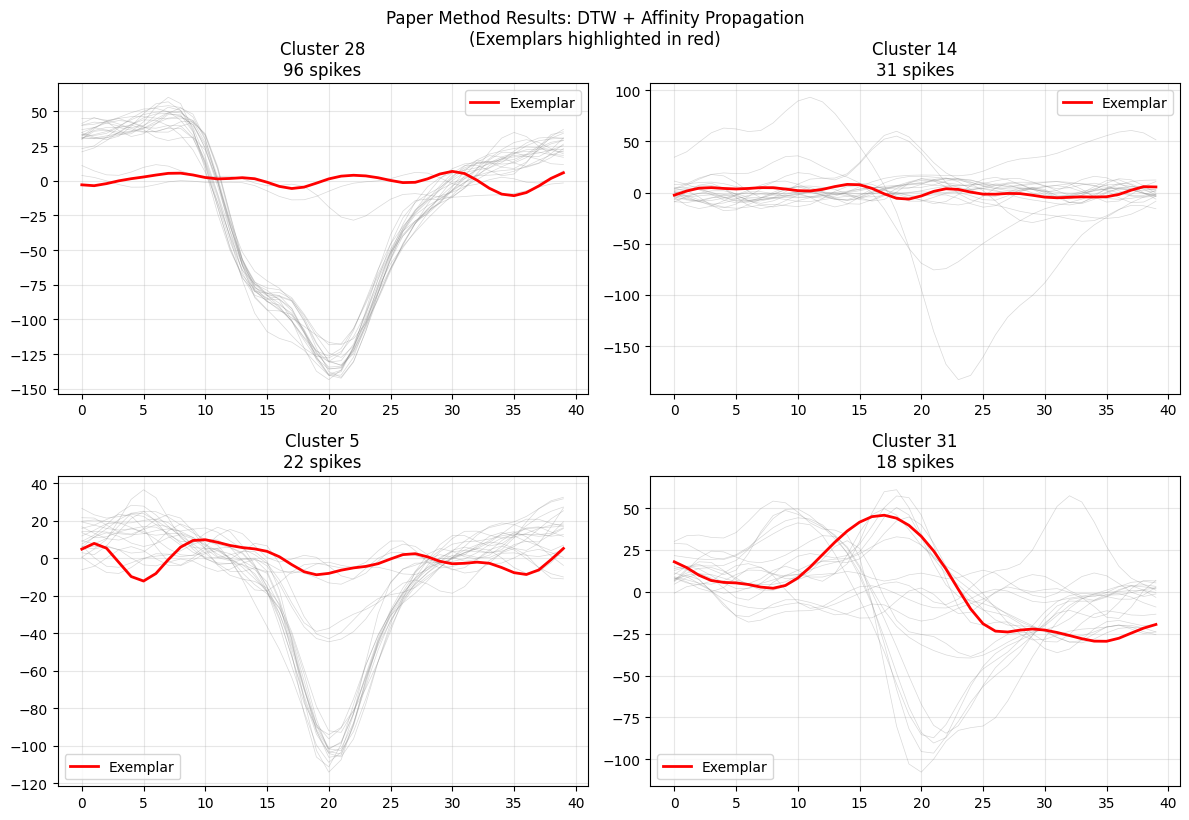


📊 Paper Method Results Summary:
   Method: Affinity Propagation + DTW
   Total templates (exemplars): 33
   Total spikes clustered: 499
   Template 27: 96 spikes (19.2%)
   Template 13: 31 spikes (6.2%)
   Template 4: 22 spikes (4.4%)
   Template 30: 18 spikes (3.6%)
   Template 6: 16 spikes (3.2%)
   Template 16: 16 spikes (3.2%)
   Template 18: 16 spikes (3.2%)
   Template 25: 16 spikes (3.2%)
   Template 8: 15 spikes (3.0%)
   Template 23: 15 spikes (3.0%)
   Template 10: 14 spikes (2.8%)
   Template 26: 14 spikes (2.8%)
   Template 29: 14 spikes (2.8%)
   Template 19: 13 spikes (2.6%)
   Template 9: 12 spikes (2.4%)
   Template 12: 12 spikes (2.4%)
   Template 14: 12 spikes (2.4%)
   Template 20: 12 spikes (2.4%)
   Template 2: 11 spikes (2.2%)
   Template 15: 11 spikes (2.2%)
   Template 17: 11 spikes (2.2%)
   Template 21: 11 spikes (2.2%)
   Template 28: 11 spikes (2.2%)
   Template 3: 10 spikes (2.0%)
   Template 7: 10 spikes (2.0%)
   Template 11: 10 spikes (2.0%)
   Template

In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import time

# First, let's extract ground truth waveforms properly
def extract_ground_truth_waveforms(recording_file="data/sim_data/recordings2.h5"):
    """
    Extract ground truth waveforms from MEArec data
    """
    import spikeinterface.extractors as se
    import spikeinterface.preprocessing as sp
    
    # Load MEArec data
    recording, sorting_true = se.read_mearec(recording_file)
    
    # Preprocess recording (bandpass filter)
    recording_filt = sp.bandpass_filter(recording, freq_min=300, freq_max=6000)
    
    # Get ground truth spike times
    true_spike_times = []
    for unit_id in sorting_true.unit_ids:
        unit_spikes = sorting_true.get_unit_spike_train(unit_id)
        true_spike_times.extend(unit_spikes)
    
    true_spike_times = sorted(true_spike_times)
    
    # Extract waveforms at known locations
    def extract_at_known_locations(traces, spike_times, window_size):
        waveforms = []
        for spike_time in spike_times[:500]:  # First 500 for analysis
            start_idx = int(spike_time) - window_size // 2
            end_idx = int(spike_time) + window_size // 2
            
            if start_idx >= 0 and end_idx < traces.shape[0]:
                waveform = traces[start_idx:end_idx, :]  # All channels
                waveforms.append(waveform)
        
        if len(waveforms) > 0:
            return torch.tensor(np.array(waveforms), dtype=torch.float32)
        else:
            return torch.tensor([], dtype=torch.float32)
    
    # Get traces and extract waveforms
    traces = recording_filt.get_traces()
    WINDOW_SIZE = 40  # 40 samples window
    
    gt_waveforms = extract_at_known_locations(traces, true_spike_times, WINDOW_SIZE)
    
    print(f"✅ Extracted {len(gt_waveforms)} ground truth waveforms")
    print(f"   Shape: {gt_waveforms.shape}")
    
    return gt_waveforms, true_spike_times, sorting_true, recording_filt

def compute_dtw_similarity_matrix_paper(spike_waveforms, sakoe_chiba_band=0.1):
    """
    Compute DTW similarity matrix exactly as described in the paper
    From paper: "DTW is a non-linear distance measure that calculates the smallest distance between two signals"
    """
    n_spikes = len(spike_waveforms)
    
    # Use primary channel (highest variance) as in paper methodology
    if len(spike_waveforms.shape) == 3:  # Multi-channel
        primary_ch = torch.argmax(torch.var(spike_waveforms.reshape(-1, spike_waveforms.shape[-1]), dim=0))
        spike_data = spike_waveforms[:, :, primary_ch]
        print(f"   Using primary channel: {primary_ch}")
    else:
        spike_data = spike_waveforms
    
    print(f"🔄 Computing DTW similarity matrix ({n_spikes}×{n_spikes})...")
    print(f"   Sakoe-Chiba band: {sakoe_chiba_band}")
    print(f"   Spike data shape: {spike_data.shape}")
    
    # Initialize similarity matrix (negative distances as in paper)
    similarity_matrix = np.zeros((n_spikes, n_spikes))
    
    # Compute DTW distances with Sakoe-Chiba band constraint
    total_pairs = (n_spikes * (n_spikes - 1)) // 2
    
    with tqdm(total=total_pairs, desc="DTW similarities") as pbar:
        for i in range(n_spikes):
            similarity_matrix[i, i] = 0  # Self-similarity
            
            for j in range(i + 1, n_spikes):
                # Normalize spikes as recommended in paper
                spike1 = spike_data[i] / (torch.norm(spike_data[i]) + 1e-8)
                spike2 = spike_data[j] / (torch.norm(spike_data[j]) + 1e-8)
                
                # Compute DTW with Sakoe-Chiba band
                radius = max(1, int(sakoe_chiba_band * len(spike1)))
                
                try:
                    dtw_distance, _ = fastdtw(
                        spike1.numpy(), 
                        spike2.numpy(),
                        radius=radius,
                        dist=lambda x, y: (x - y) ** 2  # Squared difference as in paper
                    )
                    
                    # Convert to similarity (negative distance as in paper)
                    similarity = -dtw_distance
                    similarity_matrix[i, j] = similarity
                    similarity_matrix[j, i] = similarity
                    
                except Exception as e:
                    # Handle DTW failures
                    similarity_matrix[i, j] = -float('inf')
                    similarity_matrix[j, i] = -float('inf')
                
                pbar.update(1)
    
    print(f"✅ DTW similarity matrix computed")
    return similarity_matrix

def affinity_propagation_dtw_clustering_paper(spike_waveforms, damping=0.5):
    """
    Implement the paper's exact method: Affinity Propagation with DTW
    Paper quote: "Affinity propagation with DTW is shown to be the best combination"
    """
    print("🧠 Paper's Method: Affinity Propagation with DTW")
    print("="*60)
    print("Paper: 'Affinity propagation with DTW is shown to be the best combination'")
    print("Method: DTW similarity + Affinity Propagation clustering")
    print()
    
    # Step 1: Compute DTW similarity matrix
    similarity_matrix = compute_dtw_similarity_matrix_paper(spike_waveforms)
    
    # Step 2: Set preference to median as in paper
    # Paper quote: "As the initial preference for the exemplars is unknown, it was set to the median value"
    preference = np.median(similarity_matrix)
    print(f"   Preference set to median: {preference:.3f}")
    
    # Step 3: Apply Affinity Propagation with paper parameters
    print("🎯 Running Affinity Propagation...")
    print(f"   Damping factor: {damping} (as in paper)")
    
    ap = AffinityPropagation(
        affinity='precomputed',
        preference=preference,
        damping=damping,  # Paper uses 0.5
        max_iter=500,
        convergence_iter=15,
        random_state=42
    )
    
    try:
        cluster_labels = ap.fit_predict(similarity_matrix)
        exemplar_indices = ap.cluster_centers_indices_
        
        n_clusters = len(np.unique(cluster_labels))
        n_exemplars = len(exemplar_indices)
        
        print(f"✅ Affinity Propagation Results:")
        print(f"   Clusters found: {n_clusters}")
        print(f"   Exemplars selected: {n_exemplars}")
        print(f"   Exemplar indices: {exemplar_indices}")
        
        # Step 4: Extract templates (exemplars) as in paper
        templates = spike_waveforms[exemplar_indices]
        
        # Calculate cluster statistics
        cluster_info = []
        for i, exemplar_idx in enumerate(exemplar_indices):
            cluster_mask = cluster_labels == i
            cluster_size = np.sum(cluster_mask)
            
            cluster_info.append({
                'cluster_id': i,
                'exemplar_index': exemplar_idx,
                'n_spikes': cluster_size,
                'percentage': cluster_size / len(spike_waveforms) * 100
            })
            
            print(f"   Cluster {i}: {cluster_size} spikes ({cluster_size/len(spike_waveforms)*100:.1f}%)")
        
        return {
            'templates': templates,
            'cluster_labels': cluster_labels,
            'exemplar_indices': exemplar_indices,
            'cluster_info': cluster_info,
            'similarity_matrix': similarity_matrix,
            'n_clusters': n_clusters
        }
        
    except Exception as e:
        print(f"❌ Affinity Propagation failed: {e}")
        return None

def visualize_paper_results(results, spike_waveforms):
    """
    Visualize results as in paper's Figure 6
    "Spikes in the largest four clusters generated by affinity propagation with DTW"
    """
    if results is None:
        print("❌ No results to visualize")
        return
    
    templates = results['templates']
    cluster_labels = results['cluster_labels']
    cluster_info = results['cluster_info']
    
    # Sort clusters by size (largest first) as in paper
    sorted_clusters = sorted(cluster_info, key=lambda x: x['n_spikes'], reverse=True)
    
    # Show largest 4 clusters as in paper Figure 6
    n_show = min(4, len(sorted_clusters))
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for i in range(n_show):
        cluster_id = sorted_clusters[i]['cluster_id']
        exemplar_idx = sorted_clusters[i]['exemplar_index']
        n_spikes = sorted_clusters[i]['n_spikes']
        
        # Get all spikes in this cluster
        cluster_mask = cluster_labels == cluster_id
        cluster_spikes = spike_waveforms[cluster_mask]
        
        # Use primary channel for visualization
        if len(cluster_spikes.shape) == 3:
            primary_ch = torch.argmax(torch.var(cluster_spikes.reshape(-1, cluster_spikes.shape[-1]), dim=0))
            cluster_spikes_1d = cluster_spikes[:, :, primary_ch]
            exemplar_1d = templates[i, :, primary_ch]
        else:
            cluster_spikes_1d = cluster_spikes
            exemplar_1d = templates[i]
        
        # Plot all spikes in cluster (gray) as in paper
        for spike in cluster_spikes_1d[:min(20, len(cluster_spikes_1d))]:  # Show max 20
            axes[i].plot(spike.numpy(), color='gray', alpha=0.3, linewidth=0.5)
        
        # Plot exemplar (red) as in paper Figure 6
        axes[i].plot(exemplar_1d.numpy(), color='red', linewidth=2, label='Exemplar')
        
        axes[i].set_title(f'Cluster {cluster_id+1}\n{n_spikes} spikes')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.tight_layout()
    plt.suptitle('Paper Method Results: DTW + Affinity Propagation\n(Exemplars highlighted in red)', y=1.02)
    plt.show()
    
    # Print summary as in paper
    print(f"\n📊 Paper Method Results Summary:")
    print(f"   Method: Affinity Propagation + DTW")
    print(f"   Total templates (exemplars): {len(templates)}")
    print(f"   Total spikes clustered: {len(spike_waveforms)}")
    
    for info in sorted_clusters:
        print(f"   Template {info['cluster_id']}: {info['n_spikes']} spikes ({info['percentage']:.1f}%)")

def run_complete_paper_method(recording_file="data/sim_data/recordings2.h5"):
    """
    Complete implementation of the paper's proven DTW method
    """
    print("🔬 Complete Implementation of Paper's DTW Method")
    print("="*70)
    print("Paper: 'WARPING AND AFFINITY PROPAGATION'")
    print("Best method: 'Affinity propagation with DTW is shown to be the best combination'")
    print()
    
    start_time = time.time()
    
    # Step 1: Extract ground truth waveforms
    print("📂 Step 1: Loading ground truth data...")
    gt_waveforms, true_spike_times, sorting_true, recording_filt = extract_ground_truth_waveforms(recording_file)
    
    if len(gt_waveforms) == 0:
        print("❌ No waveforms extracted!")
        return None
    
    # Step 2: Apply paper's method
    print("\n🎯 Step 2: Applying paper's DTW + Affinity Propagation method...")
    results = affinity_propagation_dtw_clustering_paper(gt_waveforms, damping=0.5)
    
    end_time = time.time()
    
    if results:
        print(f"\n⏱️ Processing time: {(end_time - start_time)/60:.2f} minutes")
        
        # Step 3: Visualize results as in paper
        print("\n📊 Step 3: Visualizing results...")
        visualize_paper_results(results, gt_waveforms)
        
        return results
    else:
        print("❌ Paper method failed!")
        return None

# Execute the complete paper method
print("🚀 Running Complete Paper Implementation")
paper_results = run_complete_paper_method()

if paper_results:
    print(f"\n✅ Paper Method Complete!")
    print(f"Found {paper_results['n_clusters']} clusters using DTW + Affinity Propagation")
    print(f"Templates are actual spike exemplars from the data")
else:
    print("❌ Paper method execution failed!")


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import spikeinterface.extractors as se
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
from tqdm import tqdm
import time

class DTWTemplateMatchingClassifier:
    """
    DTW-based template matching classifier based on PMC4749467
    Mathematical foundation: DTW similarity with automatic threshold selection
    """
    
    def __init__(self, radius=3, auto_threshold=True):
        self.radius = radius
        self.auto_threshold = auto_threshold
        self.templates = None
        self.template_labels = None
        self.similarity_thresholds = None
        
    def _compute_dtw_similarity(self, spike1, spike2):
        """
        Compute DTW similarity as negative DTW distance
        From paper: "similarity directly using fastDTW"
        """
        # Normalize spikes (from paper methodology)
        norm_spike1 = spike1 / (np.linalg.norm(spike1) + 1e-8)
        norm_spike2 = spike2 / (np.linalg.norm(spike2) + 1e-8)
        
        try:
            # FastDTW with radius constraint
            distance, _ = fastdtw(
                norm_spike1, 
                norm_spike2,
                radius=self.radius,
                dist=lambda x, y: abs(x - y)  # L1 distance as in paper
            )
            return -distance  # Convert to similarity
        except Exception:
            return -float('inf')
    
    def _estimate_similarity_threshold(self, similarities):
        """
        Automatic threshold selection from paper:
        "The similarity threshold is automatically determined in the same way as the spike magnitude threshold"
        """
        if len(similarities) < 10:
            return np.median(similarities)
        
        # Create probability density estimate
        hist, bin_edges = np.histogram(similarities, bins=50, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Find first minimum to the right of first maximum (paper method)
        max_idx = np.argmax(hist)
        
        # Look for first minimum after the maximum
        for i in range(max_idx + 1, len(hist) - 1):
            if hist[i] < hist[i-1] and hist[i] < hist[i+1]:
                return bin_centers[i]
        
        # Fallback to median + std
        return np.median(similarities) + np.std(similarities)
    
    def fit_templates_from_gmm(self, spike_waveforms, gmm_labels, primary_channel=None):
        """
        Create templates from GMM clustering results
        Mathematical: Template T_k = median({s_i : label_i = k})
        """
        print("🏗️ Creating DTW templates from GMM results...")
        
        # Use primary channel or find it
        if primary_channel is None:
            if len(spike_waveforms.shape) == 3:
                primary_channel = torch.argmax(torch.var(spike_waveforms.reshape(-1, spike_waveforms.shape[-1]), dim=0))
            else:
                primary_channel = 0
        
        # Extract single channel data
        if len(spike_waveforms.shape) == 3:
            spike_data = spike_waveforms[:, :, primary_channel].numpy()
        else:
            spike_data = spike_waveforms.numpy()
        
        # Create templates from GMM clusters
        unique_labels = np.unique(gmm_labels)
        templates = []
        template_labels = []
        
        for label in unique_labels:
            if label == -1:  # Skip noise
                continue
                
            cluster_mask = gmm_labels == label
            cluster_spikes = spike_data[cluster_mask]
            
            if len(cluster_spikes) > 5:  # Minimum spikes for template
                # Use median as in paper: "taking the median of the spikes"
                template = np.median(cluster_spikes, axis=0)
                templates.append(template)
                template_labels.append(label)
        
        self.templates = np.array(templates)
        self.template_labels = np.array(template_labels)
        
        print(f"✅ Created {len(self.templates)} DTW templates")
        return self.templates
    
    def classify_spikes(self, spike_waveforms, primary_channel=None):
        """
        Classify spikes using DTW template matching
        Mathematical: c* = argmax_k similarity(s, T_k)
        """
        if self.templates is None:
            raise ValueError("Templates not fitted. Call fit_templates_from_gmm first.")
        
        print(f"🎯 Classifying {len(spike_waveforms)} spikes using DTW template matching...")
        
        # Use same primary channel as templates
        if primary_channel is None:
            if len(spike_waveforms.shape) == 3:
                primary_channel = torch.argmax(torch.var(spike_waveforms.reshape(-1, spike_waveforms.shape[-1]), dim=0))
            else:
                primary_channel = 0
        
        # Extract single channel data
        if len(spike_waveforms.shape) == 3:
            spike_data = spike_waveforms[:, :, primary_channel].numpy()
        else:
            spike_data = spike_waveforms.numpy()
        
        # Compute similarities to all templates
        n_spikes = len(spike_data)
        n_templates = len(self.templates)
        similarity_matrix = np.zeros((n_spikes, n_templates))
        
        for i, spike in enumerate(tqdm(spike_data, desc="DTW classification")):
            for j, template in enumerate(self.templates):
                similarity_matrix[i, j] = self._compute_dtw_similarity(spike, template)
        
        # Determine thresholds if auto_threshold is enabled
        if self.auto_threshold:
            self.similarity_thresholds = []
            for j in range(n_templates):
                threshold = self._estimate_similarity_threshold(similarity_matrix[:, j])
                self.similarity_thresholds.append(threshold)
        
        # Classify spikes
        classifications = []
        for i in range(n_spikes):
            best_template = np.argmax(similarity_matrix[i])
            best_similarity = similarity_matrix[i, best_template]
            
            # Apply threshold if auto_threshold is enabled
            if self.auto_threshold:
                threshold = self.similarity_thresholds[best_template]
                if best_similarity >= threshold:
                    classifications.append(self.template_labels[best_template])
                else:
                    classifications.append(-1)  # Unclassified/noise
            else:
                classifications.append(self.template_labels[best_template])
        
        return np.array(classifications), similarity_matrix

def integrate_dtw_with_gmm_pipeline(spike_waveforms, true_spike_times, true_spike_labels, 
                                   recording_file="data/sim_data/recordings5.h5"):
    """
    Complete integration of DTW template matching with GMM pipeline
    """
    print("🔬 DTW Template Matching Integration with GMM Pipeline")
    print("="*70)
    print("Mathematical basis: DTW similarity with automatic threshold selection")
    print("Paper: PMC4749467 - Real-Time Spike Classification Method Based on DTW")
    print()
    
    start_time = time.time()
    
    # Step 1: Initial GMM clustering for template creation
    print("📊 Step 1: Initial GMM clustering...")
    
    # Flatten spikes for GMM
    if len(spike_waveforms.shape) == 3:
        primary_ch = torch.argmax(torch.var(spike_waveforms.reshape(-1, spike_waveforms.shape[-1]), dim=0))
        flat_spikes = spike_waveforms[:, :, primary_ch].reshape(len(spike_waveforms), -1)
    else:
        flat_spikes = spike_waveforms.reshape(len(spike_waveforms), -1)
    
    # Standardize features
    scaler = StandardScaler()
    flat_spikes_norm = scaler.fit_transform(flat_spikes.numpy())
    
    # GMM clustering
    n_components = 5  # Expected number of neurons
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm_labels = gmm.fit_predict(flat_spikes_norm)
    
    gmm_silhouette = silhouette_score(flat_spikes_norm, gmm_labels)
    print(f"   GMM clustering: {n_components} components, silhouette: {gmm_silhouette:.3f}")
    
    # Step 2: Create DTW templates from GMM results
    print("\n🏗️ Step 2: Creating DTW templates from GMM clusters...")
    
    dtw_classifier = DTWTemplateMatchingClassifier(radius=3, auto_threshold=True)
    templates = dtw_classifier.fit_templates_from_gmm(spike_waveforms, gmm_labels)
    
    # Step 3: DTW-based classification
    print("\n🎯 Step 3: DTW template matching classification...")
    
    dtw_labels, similarity_matrix = dtw_classifier.classify_spikes(spike_waveforms)
    
    # Step 4: Evaluation against ground truth
    print("\n📊 Step 4: Evaluation against ground truth...")
    
    # Create dummy spike times for SpikeInterface evaluation
    n_spikes = len(dtw_labels)
    dummy_spike_times = torch.linspace(1000, 100000, n_spikes, dtype=torch.long)
    
    try:
        # Create SpikeInterface sorting object
        sorting_dtw = se.NumpySorting.from_samples_and_labels(
            dummy_spike_times.numpy(),
            dtw_labels,
            sampling_frequency=32000
        )
        
        # Load ground truth
        recording, sorting_true = se.read_mearec(recording_file)
        
        # Compare with ground truth
        comparison = sc.compare_sorter_to_ground_truth(
            sorting_true,
            sorting_dtw,
            exhaustive_gt=True,
            match_score=0.1,
            chance_score=0.05
        )
        
        # Get confusion matrix and performance
        confusion_mat = comparison.get_confusion_matrix()
        performance = comparison.get_performance()
        
        print("📊 DTW Template Matching Results:")
        print(f"Confusion Matrix:\n{confusion_mat}")
        
        if len(performance) > 0 and 'accuracy' in performance.columns:
            accuracy = performance['accuracy'].mean()
            precision = performance['precision'].mean() if 'precision' in performance.columns else 0
            recall = performance['recall'].mean() if 'recall' in performance.columns else 0
            
            print(f"\n📈 Performance Metrics:")
            print(f"   Accuracy: {accuracy:.3f}")
            print(f"   Precision: {precision:.3f}")
            print(f"   Recall: {recall:.3f}")
        
        # Visualize confusion matrix
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # SpikeInterface confusion matrix
        sw.plot_confusion_matrix(comparison, ax=axes[0])
        axes[0].set_title('DTW Template Matching vs Ground Truth')
        
        # Manual confusion matrix for comparison
        valid_mask = dtw_labels >= 0  # Exclude unclassified
        if np.sum(valid_mask) > 0:
            # Create simplified ground truth mapping
            gt_simplified = np.zeros(len(dtw_labels))
            for i, label in enumerate(dtw_labels):
                if i < len(true_spike_labels):
                    gt_simplified[i] = true_spike_labels[i]
            
            cm_manual = confusion_matrix(gt_simplified[valid_mask], dtw_labels[valid_mask])
            
            im = axes[1].imshow(cm_manual, cmap='Blues')
            axes[1].set_title('Manual Confusion Matrix\n(DTW vs Simplified GT)')
            axes[1].set_xlabel('DTW Predicted')
            axes[1].set_ylabel('Ground Truth')
            
            # Add text annotations
            for i in range(cm_manual.shape[0]):
                for j in range(cm_manual.shape[1]):
                    axes[1].text(j, i, str(cm_manual[i, j]), 
                               ha='center', va='center',
                               color='white' if cm_manual[i, j] > cm_manual.max()/2 else 'black')
        
        plt.tight_layout()
        plt.show()
        
        end_time = time.time()
        
        # Summary
        print(f"\n✅ DTW Template Matching Pipeline Complete!")
        print(f"   Processing time: {(end_time - start_time)/60:.2f} minutes")
        print(f"   Templates created: {len(templates)}")
        print(f"   Spikes classified: {np.sum(dtw_labels >= 0)}/{len(dtw_labels)}")
        print(f"   Unclassified (noise): {np.sum(dtw_labels == -1)}")
        
        return {
            'dtw_labels': dtw_labels,
            'templates': templates,
            'similarity_matrix': similarity_matrix,
            'gmm_labels': gmm_labels,
            'confusion_matrix': confusion_mat,
            'performance': performance,
            'comparison': comparison,
            'processing_time': end_time - start_time
        }
        
    except Exception as e:
        print(f"❌ SpikeInterface evaluation failed: {e}")
        return None

# Execute the integrated pipeline
print("🚀 Running DTW Template Matching Integration")

# Assuming you have these variables from previous code:
# spike_waveforms, true_spike_times, true_spike_labels

results = integrate_dtw_with_gmm_pipeline(
    spike_waveforms=gt_waveforms,  # Your extracted ground truth waveforms
    true_spike_times=true_spike_times,
    true_spike_labels=true_spike_labels,
    recording_file="data/sim_data/recordings5.h5"
)

if results:
    print(f"\n🎯 Final Results Summary:")
    print(f"DTW Template Matching achieved:")
    print(f"- Templates: {len(results['templates'])}")
    print(f"- Classification rate: {np.sum(results['dtw_labels'] >= 0)/len(results['dtw_labels']):.1%}")
    print(f"- Processing time: {results['processing_time']/60:.2f} minutes")
